In [1]:
# from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
# from keras.models import Model
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input
# from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
# from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [2]:
import keras.backend as K

def categorical_focal_loss(alpha, gamma=2.):

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

In [3]:
import dill

custom_object = {'categorical_focal_loss_fixed': dill.loads(dill.dumps(categorical_focal_loss(gamma=2., alpha=0.25)))}

In [4]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# useful for getting number of classes
folders = glob('C:/Drowsy/data/train/*')
print("Number of folders,\n",folders)

Number of folders,
 ['C:/Users/wweis/Deep Learning/Drowsy/data/train\\Closed', 'C:/Users/wweis/Deep Learning/Drowsy/data/train\\no_yawn', 'C:/Users/wweis/Deep Learning/Drowsy/data/train\\Open', 'C:/Users/wweis/Deep Learning/Drowsy/data/train\\yawn']


In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('C:/Drowsy/data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=42)

# validation_set = test_datagen.flow_from_directory('C:/Drowsy/data/valid',
#                                                   target_size=(224, 224),
#                                                   batch_size=1,
#                                                   class_mode='categorical',
#                                                   shuffle=False,
#                                                   seed=42)

test_set = test_datagen.flow_from_directory('C:/Drowsy/data/test',
                                            target_size = (224, 224),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False,
                                            seed=42)

Found 2030 images belonging to 4 classes.
Found 580 images belonging to 4 classes.


In [7]:
from keras.models import load_model

saved_model = load_model("models/CE_Drowsy.h5")
# saved_model = load_model("models/FL_Drowsy.h5", custom_objects=custom_object)

In [8]:
score_valid = saved_model.evaluate(test_set)

580/580 [==============================] - 17s 25ms/step - loss: 1.1228 - branch_1_loss: 0.4164 - branch_2_loss: 0.3307 - branch_3_loss: 0.1176 - branch_4_loss: 0.1693 - fine_branch_loss: 0.0888 - branch_1_accuracy: 0.8155 - branch_2_accuracy: 0.8534 - branch_3_accuracy: 0.9621 - branch_4_accuracy: 0.9466 - fine_branch_accuracy: 0.9759


In [9]:
pred = saved_model.predict(test_set)

# Get the number of unique labels
num_labels = len(np.unique(test_set.classes))

predicted_class_indices = []

for branch in range(5):
    predicted_class_indices.append(np.argmax(pred[branch],axis=1))

# Define a list of label names
label_names = ['Closed', 'no_yawn', 'Open', 'yawn']

# Compute the accuracy for each label
for branch in range(5):
    predicted_class = predicted_class_indices[branch]

    label_accs = {}
    for label in range(num_labels):
        idx = np.where(test_set.classes == label)[0]
        label_acc = np.mean(predicted_class[idx] == test_set.classes[idx])
        label_accs[label_names[label]] = label_acc

    # Print the accuracy for each label
    for label, acc in label_accs.items():
        print(f"Accuracy for label {label}: {acc:.2f}")
    print("\n")

Accuracy for label Closed: 1.00
Accuracy for label no_yawn: 0.79
Accuracy for label Open: 0.74
Accuracy for label yawn: 0.74


Accuracy for label Closed: 0.83
Accuracy for label no_yawn: 1.00
Accuracy for label Open: 0.78
Accuracy for label yawn: 0.80


Accuracy for label Closed: 0.99
Accuracy for label no_yawn: 0.98
Accuracy for label Open: 0.95
Accuracy for label yawn: 0.93


Accuracy for label Closed: 1.00
Accuracy for label no_yawn: 0.97
Accuracy for label Open: 0.83
Accuracy for label yawn: 0.99


Accuracy for label Closed: 0.99
Accuracy for label no_yawn: 0.97
Accuracy for label Open: 0.98
Accuracy for label yawn: 0.97




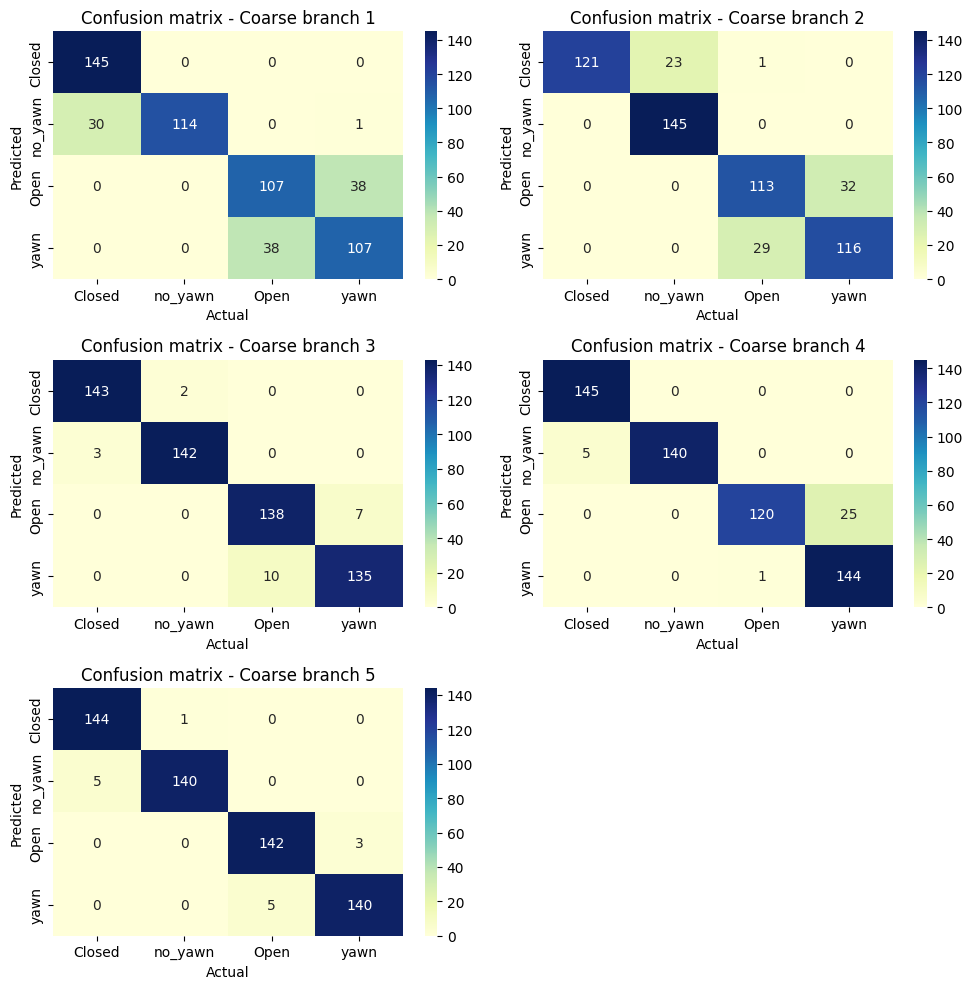

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

plt.figure(figsize=(10, 10))

# Get the true labels for the test set
y_true = test_set.classes

# Iterate over each branch
for branch in range(5):
    # Compute the confusion matrix for the current branch
    conf_mat = confusion_matrix(y_true, predicted_class_indices[branch])

    df_cm = pd.DataFrame(conf_mat, index=['Closed', 'no_yawn', 'Open', 'yawn'], 
                         columns=['Closed', 'no_yawn', 'Open', 'yawn'])

    # Create a subplot for the current branch
    plt.subplot(3, 2, branch+1)  # Adjust the subplot layout as needed
    plt.title("Confusion matrix - Coarse branch {}".format(branch+1))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.ylabel("Predicted")
    plt.xlabel("Actual")

# Adjust the spacing between subplots if necessary
plt.tight_layout()

# Show the plot
plt.show()


In [11]:
from sklearn.metrics import classification_report

for branch in range(5):
    # Assuming y_true and y_pred are the true and predicted labels
    report = classification_report(y_true, predicted_class_indices[branch])
    print(report)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       145
           1       1.00      0.79      0.88       145
           2       0.74      0.74      0.74       145
           3       0.73      0.74      0.74       145

    accuracy                           0.82       580
   macro avg       0.82      0.82      0.81       580
weighted avg       0.82      0.82      0.81       580

              precision    recall  f1-score   support

           0       1.00      0.83      0.91       145
           1       0.86      1.00      0.93       145
           2       0.79      0.78      0.78       145
           3       0.78      0.80      0.79       145

    accuracy                           0.85       580
   macro avg       0.86      0.85      0.85       580
weighted avg       0.86      0.85      0.85       580

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       145
           1       0.

In [12]:
branch_predictions = [score_valid[6], score_valid[7], score_valid[8], score_valid[9], score_valid[10]]

# Assuming you have the predicted probabilities from each model stored in a list
model_predictions = [pred[0], pred[1], pred[2], pred[3], pred[4]]

branch_left = len(model_predictions)

In [13]:
import pandas as pd

for m in range(branch_left-1):
    print(len(model_predictions))
    # Calculate the product of probabilities for each class across all models
    ensemble_pred_probs_product = np.prod(model_predictions, axis=0)
    ensemble_pred_probs_max = np.max(model_predictions, axis=0)
    ensemble_pred_probs_mean = np.mean(model_predictions, axis=0)

    ensemble_pred = [ensemble_pred_probs_product, ensemble_pred_probs_max, ensemble_pred_probs_mean]
    
    class_data = []

    for k in range(len(ensemble_pred)):
        data = []

        for i in range(len(pred[0])):
            sample_data = []
            sample_data.append("Sample " + str(i+1))

            for j in range(len(folders)):
                ensemble_pred_probs = ensemble_pred[k]
                sample_data.append(ensemble_pred_probs[i,j])

            data.append(sample_data)

        df = pd.DataFrame(data, columns=["Sample", 'closed', 'no yawn', 'Open', 'yawn'])
        df.to_excel("valid_"+str(m)+"_"+str(k)+".xlsx", index=False)

        # Get the predicted classes by selecting the class with the highest probability
        ensemble_pred_classes = np.argmax(ensemble_pred_probs, axis=1)

        # Print the ensemble predictions
        for i in range(len(ensemble_pred_classes)):
            class_data.append("Sample" + str(i+1))
            class_data.append(test_set.labels[i])
            class_data.append(ensemble_pred_classes[i])
#             print("Sample", i+1, ": Predicted class:", ensemble_pred_classes[i])

        # Assuming you have the true labels for the validation set stored in a variable
        true_labels = test_set.labels

        # Calculate the accuracy of the ensemble predictions
        accuracy = np.mean(ensemble_pred_classes == true_labels) * 100
        class_data.extend(["Accuracy", "", accuracy])

        print("Ensemble accuracy on the valid set: {:.2f}%".format(accuracy))
        
        df1 = pd.DataFrame(np.array(class_data).reshape(-1, 3), columns=["Sample", 'Actual', 'Predicted'])
        df1.to_excel("Predicted_valid_"+str(m)+".xlsx", index=False)
    
    if(len(model_predictions)>2):
        lowest_accuracy_branch_idx = np.argmin(branch_predictions)
        branch_predictions.pop(lowest_accuracy_branch_idx)
        model_predictions.pop(lowest_accuracy_branch_idx)
    
    print("-----------------------------------------------------------------------------------------------------")

5
Ensemble accuracy on the valid set: 97.24%
Ensemble accuracy on the valid set: 96.90%
Ensemble accuracy on the valid set: 96.72%
-----------------------------------------------------------------------------------------------------
4
Ensemble accuracy on the valid set: 97.76%
Ensemble accuracy on the valid set: 97.07%
Ensemble accuracy on the valid set: 97.59%
-----------------------------------------------------------------------------------------------------
3
Ensemble accuracy on the valid set: 97.41%
Ensemble accuracy on the valid set: 97.07%
Ensemble accuracy on the valid set: 97.41%
-----------------------------------------------------------------------------------------------------
2
Ensemble accuracy on the valid set: 97.24%
Ensemble accuracy on the valid set: 97.24%
Ensemble accuracy on the valid set: 97.24%
-----------------------------------------------------------------------------------------------------
